# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [4]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [5]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [6]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.419
[2] loss: 0.240
[3] loss: 0.072
[4] loss: 0.038
[5] loss: 0.022
[6] loss: 0.017
[7] loss: 0.011
[8] loss: 0.010
[9] loss: 0.010
[10] loss: 0.007
[11] loss: 0.006
[12] loss: 0.008
[13] loss: 0.005
[14] loss: 0.004
[15] loss: 0.005
[16] loss: 0.003
[17] loss: 0.004
[18] loss: 0.003
[19] loss: 0.004
[20] loss: 0.003


In [7]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [8]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

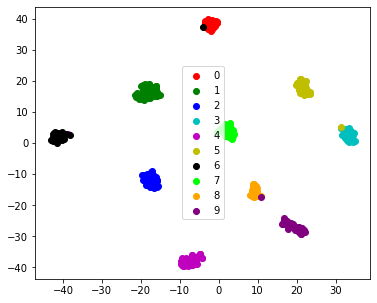

In [9]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

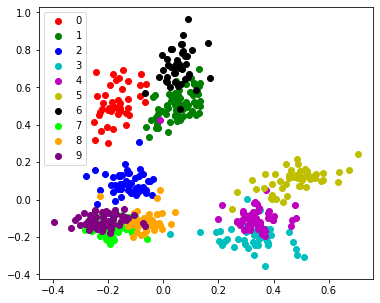

In [10]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [11]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [12]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [13]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1595,  0.0601, -0.1265,  0.3317,  0.3529,  0.4952,  0.0586, -0.1762,
         -0.0751, -0.2276],
        [-0.1709,  0.3621,  0.6181, -0.0647, -0.2427, -0.0119, -0.2121,  0.5214,
         -0.2422, -0.2258],
        [ 0.5144,  0.4902,  0.0686, -0.2067, -0.0896,  0.1221,  0.7101, -0.1489,
         -0.1180, -0.1102],
        [-0.0525, -0.2377,  0.3617, -0.0024, -0.2454, -0.0771,  0.1513, -0.2384,
          0.5424, -0.2100],
        [-0.2652,  0.2465, -0.2058,  0.5677, -0.0416, -0.2569, -0.2293, -0.1626,
          0.0031,  0.4923],
        [ 0.4559, -0.1085, -0.3124, -0.3235,  0.4208, -0.2940, -0.3213,  0.2581,
          0.0887,  0.2295]])

In [14]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [15]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [16]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [18]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [28]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_5.cfg')

['./config/sswae_dev2_1_5.cfg']

In [29]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
#mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.338601e-01  D: 6.926156e-01  D2: 2.546899e-02  D3: 4.956695e-03
test loss: 1.744631e-01  D: 6.903246e-01  D2: 2.416935e-03  D3: 8.347931e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.648297e-01  D: 6.945608e-01  D2: 2.504539e-04  D3: 7.696059e-03
test loss: 1.591094e-01  D: 7.091200e-01  D2: -3.360825e-03  D3: 7.437931e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.527630e-01  D: 6.948063e-01  D2: -3.586756e-03  D3: 8.634459e-03
test loss: 1.397776e-01  D: 7.045680e-01  D2: -3.096504e-03  D3: 8.384115e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.313321e-01  D: 6.938420e-01  D2: -4.051313e-03  D3: 9.340460e-03
test loss: 1.157799e-01  D: 6.960501e-01  D2: -3.981495e-03  D3: 1.077714e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.186894e-01  D: 6.953337e-01  D2: -3.896001e-03  D3: 1.299925e-02
test loss: 1.112703e-01  D: 7.101123e-01  D2: -3.360863e-03  D3: 1.656207e-02


[default |INFO|model.py:1280] [06/80]  loss: 1.052542e-01  D: 6.936312e-01  D2: -4.078821e-03  D3: 1.412007e-02
test loss: 1.024372e-01  D: 6.883577e-01  D2: -3.340034e-03  D3: 1.410597e-02


[default |INFO|model.py:1280] [07/80]  loss: 9.727363e-02  D: 6.937582e-01  D2: -4.303204e-03  D3: 1.411453e-02
test loss: 9.367318e-02  D: 6.925495e-01  D2: -3.700886e-03  D3: 1.429987e-02


[default |INFO|model.py:1280] [08/80]  loss: 9.260639e-02  D: 6.936769e-01  D2: -4.392233e-03  D3: 1.422016e-02
test loss: 9.144304e-02  D: 6.975292e-01  D2: -3.303919e-03  D3: 1.449221e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.986993e-02  D: 6.935493e-01  D2: -4.581005e-03  D3: 1.384127e-02
test loss: 8.746583e-02  D: 7.072764e-01  D2: -4.195032e-03  D3: 1.381727e-02


[default |INFO|model.py:1280] [10/80]  loss: 8.861951e-02  D: 6.931610e-01  D2: -4.665244e-03  D3: 1.338893e-02
test loss: 8.596566e-02  D: 6.930582e-01  D2: -5.214396e-03  D3: 1.327229e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.818508e-02  D: 6.949651e-01  D2: -4.599867e-03  D3: 1.294639e-02
test loss: 8.568297e-02  D: 6.974395e-01  D2: -3.308516e-03  D3: 1.429723e-02


[default |INFO|model.py:1280] [12/80]  loss: 8.717993e-02  D: 6.932494e-01  D2: -5.032015e-03  D3: 1.251485e-02
test loss: 8.985452e-02  D: 7.082301e-01  D2: -5.612526e-03  D3: 1.584716e-02


[default |INFO|model.py:1280] [13/80]  loss: 8.620712e-02  D: 6.940403e-01  D2: -5.041296e-03  D3: 1.261855e-02
test loss: 8.362340e-02  D: 7.018660e-01  D2: -3.910217e-03  D3: 1.280878e-02


[default |INFO|model.py:1280] [14/80]  loss: 8.420803e-02  D: 6.933047e-01  D2: -5.013110e-03  D3: 1.302299e-02
test loss: 8.343789e-02  D: 6.936283e-01  D2: -5.664368e-03  D3: 1.109671e-02


[default |INFO|model.py:1280] [15/80]  loss: 8.307614e-02  D: 6.938278e-01  D2: -5.405099e-03  D3: 1.254126e-02
test loss: 8.246604e-02  D: 6.892208e-01  D2: -6.261301e-03  D3: 9.906289e-03


[default |INFO|model.py:1280] [16/80]  loss: 8.202509e-02  D: 6.934381e-01  D2: -5.481222e-03  D3: 1.296875e-02
test loss: 8.034264e-02  D: 6.968072e-01  D2: -5.036678e-03  D3: 1.285108e-02


[default |INFO|model.py:1280] [17/80]  loss: 8.012049e-02  D: 6.932114e-01  D2: -5.468844e-03  D3: 1.300211e-02
test loss: 8.003442e-02  D: 6.888564e-01  D2: -6.164255e-03  D3: 1.162719e-02


[default |INFO|model.py:1280] [18/80]  loss: 8.088129e-02  D: 6.937379e-01  D2: -5.635665e-03  D3: 1.239088e-02
test loss: 8.586959e-02  D: 6.887385e-01  D2: -5.739536e-03  D3: 1.240658e-02


[default |INFO|model.py:1280] [19/80]  loss: 8.054749e-02  D: 6.941174e-01  D2: -5.689178e-03  D3: 1.220338e-02
test loss: 8.042613e-02  D: 6.866404e-01  D2: -5.489073e-03  D3: 1.309920e-02


[default |INFO|model.py:1280] [20/80]  loss: 7.869692e-02  D: 6.934658e-01  D2: -5.740835e-03  D3: 1.243973e-02
test loss: 7.806071e-02  D: 6.884019e-01  D2: -4.866352e-03  D3: 1.328683e-02


[default |INFO|model.py:1280] [21/80]  loss: 7.777751e-02  D: 6.929956e-01  D2: -5.875117e-03  D3: 1.256868e-02
test loss: 7.561702e-02  D: 6.829968e-01  D2: -5.669165e-03  D3: 1.238772e-02


[default |INFO|model.py:1280] [22/80]  loss: 7.886154e-02  D: 6.943282e-01  D2: -5.834260e-03  D3: 1.203524e-02
test loss: 7.786544e-02  D: 6.844593e-01  D2: -6.454964e-03  D3: 1.194130e-02


[default |INFO|model.py:1280] [23/80]  loss: 7.731108e-02  D: 6.933307e-01  D2: -6.174221e-03  D3: 1.246350e-02
test loss: 7.654361e-02  D: 6.906749e-01  D2: -6.067696e-03  D3: 1.300258e-02


[default |INFO|model.py:1280] [24/80]  loss: 7.671944e-02  D: 6.936011e-01  D2: -6.254721e-03  D3: 1.229738e-02
test loss: 7.790408e-02  D: 6.949397e-01  D2: -6.601648e-03  D3: 1.331180e-02


[default |INFO|model.py:1280] [25/80]  loss: 7.702195e-02  D: 6.930703e-01  D2: -6.272432e-03  D3: 1.221502e-02
test loss: 7.563170e-02  D: 7.038093e-01  D2: -6.572809e-03  D3: 1.222805e-02


[default |INFO|model.py:1280] [26/80]  loss: 7.632958e-02  D: 6.936253e-01  D2: -6.364298e-03  D3: 1.221483e-02
test loss: 7.555048e-02  D: 6.987399e-01  D2: -6.970854e-03  D3: 1.147904e-02


[default |INFO|model.py:1280] [27/80]  loss: 7.569708e-02  D: 6.939130e-01  D2: -6.545774e-03  D3: 1.203958e-02
test loss: 7.547923e-02  D: 6.953026e-01  D2: -6.234560e-03  D3: 1.252344e-02


[default |INFO|model.py:1280] [28/80]  loss: 7.559052e-02  D: 6.929082e-01  D2: -6.545320e-03  D3: 1.199919e-02
test loss: 7.630330e-02  D: 6.872881e-01  D2: -6.579294e-03  D3: 9.832404e-03


[default |INFO|model.py:1280] [29/80]  loss: 7.555594e-02  D: 6.936889e-01  D2: -6.729294e-03  D3: 1.209751e-02
test loss: 7.414657e-02  D: 6.934610e-01  D2: -6.876593e-03  D3: 1.133517e-02


[default |INFO|model.py:1280] [30/80]  loss: 7.506027e-02  D: 6.929491e-01  D2: -6.741012e-03  D3: 1.207927e-02
test loss: 7.569277e-02  D: 6.965853e-01  D2: -6.369028e-03  D3: 1.325059e-02


[default |INFO|model.py:1280] [31/80]  loss: 7.479959e-02  D: 6.932492e-01  D2: -6.780553e-03  D3: 1.187184e-02
test loss: 7.714690e-02  D: 6.913834e-01  D2: -6.733675e-03  D3: 1.184199e-02


[default |INFO|model.py:1280] [32/80]  loss: 7.488579e-02  D: 6.932084e-01  D2: -6.973899e-03  D3: 1.193180e-02
test loss: 7.634016e-02  D: 6.862466e-01  D2: -7.111244e-03  D3: 1.075217e-02


[default |INFO|model.py:1280] [33/80]  loss: 7.496430e-02  D: 6.928918e-01  D2: -7.001665e-03  D3: 1.179894e-02
test loss: 7.432725e-02  D: 6.906344e-01  D2: -7.069159e-03  D3: 1.134416e-02


[default |INFO|model.py:1280] [34/80]  loss: 7.359649e-02  D: 6.932064e-01  D2: -7.144764e-03  D3: 1.189084e-02
test loss: 7.376512e-02  D: 6.998869e-01  D2: -6.815929e-03  D3: 1.207332e-02


[default |INFO|model.py:1280] [35/80]  loss: 7.349156e-02  D: 6.930417e-01  D2: -7.120434e-03  D3: 1.187705e-02
test loss: 7.615262e-02  D: 6.973916e-01  D2: -6.752272e-03  D3: 1.163443e-02


[default |INFO|model.py:1280] [36/80]  loss: 7.341334e-02  D: 6.925596e-01  D2: -7.277284e-03  D3: 1.186373e-02
test loss: 7.350707e-02  D: 6.845142e-01  D2: -7.190313e-03  D3: 1.198638e-02


[default |INFO|model.py:1280] [37/80]  loss: 7.385822e-02  D: 6.920851e-01  D2: -7.274289e-03  D3: 1.149909e-02
test loss: 7.348825e-02  D: 6.827273e-01  D2: -7.393236e-03  D3: 1.282129e-02


[default |INFO|model.py:1280] [38/80]  loss: 7.330952e-02  D: 6.928270e-01  D2: -7.401713e-03  D3: 1.161871e-02
test loss: 7.642248e-02  D: 6.912151e-01  D2: -7.195835e-03  D3: 1.054110e-02


[default |INFO|model.py:1280] [39/80]  loss: 7.377259e-02  D: 6.938227e-01  D2: -7.390688e-03  D3: 1.140357e-02
test loss: 7.394823e-02  D: 7.062713e-01  D2: -7.530107e-03  D3: 1.151597e-02


[default |INFO|model.py:1280] [40/80]  loss: 7.363719e-02  D: 6.935623e-01  D2: -7.326244e-03  D3: 1.155066e-02
test loss: 7.270077e-02  D: 6.820008e-01  D2: -6.919098e-03  D3: 1.207224e-02


[default |INFO|model.py:1280] [41/80]  loss: 7.220498e-02  D: 6.933151e-01  D2: -7.501545e-03  D3: 1.175433e-02
test loss: 7.535484e-02  D: 6.967848e-01  D2: -7.461958e-03  D3: 1.282115e-02


[default |INFO|model.py:1280] [42/80]  loss: 7.182532e-02  D: 6.929652e-01  D2: -7.661750e-03  D3: 1.165785e-02
test loss: 7.233821e-02  D: 6.856249e-01  D2: -7.841406e-03  D3: 1.148329e-02


[default |INFO|model.py:1280] [43/80]  loss: 7.224838e-02  D: 6.927873e-01  D2: -7.703520e-03  D3: 1.167068e-02
test loss: 7.343024e-02  D: 6.921821e-01  D2: -7.772579e-03  D3: 1.178757e-02


[default |INFO|model.py:1280] [44/80]  loss: 7.156595e-02  D: 6.932775e-01  D2: -7.847390e-03  D3: 1.170269e-02
test loss: 7.312378e-02  D: 6.912806e-01  D2: -7.246037e-03  D3: 1.168453e-02


[default |INFO|model.py:1280] [45/80]  loss: 7.279651e-02  D: 6.937793e-01  D2: -7.725766e-03  D3: 1.125808e-02
test loss: 7.471429e-02  D: 6.855235e-01  D2: -7.751617e-03  D3: 1.204361e-02


[default |INFO|model.py:1280] [46/80]  loss: 7.152790e-02  D: 6.929521e-01  D2: -7.921343e-03  D3: 1.160731e-02
test loss: 7.335722e-02  D: 6.993141e-01  D2: -8.017740e-03  D3: 1.175575e-02


[default |INFO|model.py:1280] [47/80]  loss: 7.139846e-02  D: 6.929986e-01  D2: -7.871869e-03  D3: 1.146221e-02
test loss: 7.147605e-02  D: 6.946345e-01  D2: -7.989874e-03  D3: 1.148868e-02


[default |INFO|model.py:1280] [48/80]  loss: 7.145033e-02  D: 6.935080e-01  D2: -7.937875e-03  D3: 1.160390e-02
test loss: 7.286472e-02  D: 6.889960e-01  D2: -8.303099e-03  D3: 1.051996e-02


[default |INFO|model.py:1280] [49/80]  loss: 7.107009e-02  D: 6.932787e-01  D2: -8.031481e-03  D3: 1.149956e-02
test loss: 7.240322e-02  D: 6.951159e-01  D2: -8.382406e-03  D3: 1.153910e-02


[default |INFO|model.py:1280] [50/80]  loss: 7.106409e-02  D: 6.934622e-01  D2: -8.083235e-03  D3: 1.147009e-02
test loss: 7.399636e-02  D: 6.893414e-01  D2: -8.269444e-03  D3: 1.114986e-02


[default |INFO|model.py:1280] [51/80]  loss: 7.061874e-02  D: 6.931327e-01  D2: -8.110539e-03  D3: 1.149431e-02
test loss: 7.088583e-02  D: 6.994043e-01  D2: -8.322554e-03  D3: 1.165808e-02


[default |INFO|model.py:1280] [52/80]  loss: 7.026134e-02  D: 6.929205e-01  D2: -8.240523e-03  D3: 1.149689e-02
test loss: 7.110139e-02  D: 6.944557e-01  D2: -7.873125e-03  D3: 1.163572e-02


[default |INFO|model.py:1280] [53/80]  loss: 6.987291e-02  D: 6.932714e-01  D2: -8.270888e-03  D3: 1.141216e-02
test loss: 7.384796e-02  D: 6.980102e-01  D2: -7.800674e-03  D3: 1.200203e-02


[default |INFO|model.py:1280] [54/80]  loss: 7.062336e-02  D: 6.934307e-01  D2: -8.279839e-03  D3: 1.133966e-02
test loss: 7.124499e-02  D: 6.902435e-01  D2: -8.154497e-03  D3: 1.094412e-02


[default |INFO|model.py:1280] [55/80]  loss: 7.000726e-02  D: 6.936264e-01  D2: -8.324113e-03  D3: 1.137705e-02
test loss: 7.224229e-02  D: 6.924796e-01  D2: -8.256226e-03  D3: 1.109761e-02


[default |INFO|model.py:1280] [56/80]  loss: 7.015538e-02  D: 6.935112e-01  D2: -8.340607e-03  D3: 1.139373e-02
test loss: 7.218481e-02  D: 6.975526e-01  D2: -8.210621e-03  D3: 1.123717e-02


[default |INFO|model.py:1280] [57/80]  loss: 7.035123e-02  D: 6.930079e-01  D2: -8.393273e-03  D3: 1.119632e-02
test loss: 7.481819e-02  D: 7.013501e-01  D2: -8.537884e-03  D3: 1.272764e-02


[default |INFO|model.py:1280] [58/80]  loss: 7.025644e-02  D: 6.941429e-01  D2: -8.393947e-03  D3: 1.127070e-02
test loss: 7.126672e-02  D: 6.916509e-01  D2: -8.129549e-03  D3: 1.121085e-02


[default |INFO|model.py:1280] [59/80]  loss: 6.959375e-02  D: 6.930457e-01  D2: -8.417244e-03  D3: 1.123190e-02
test loss: 7.065182e-02  D: 6.919392e-01  D2: -8.663988e-03  D3: 1.165529e-02


[default |INFO|model.py:1280] [60/80]  loss: 6.949644e-02  D: 6.934137e-01  D2: -8.524172e-03  D3: 1.118420e-02
test loss: 7.157958e-02  D: 6.818069e-01  D2: -8.761272e-03  D3: 1.095678e-02


[default |INFO|model.py:1280] [61/80]  loss: 6.935307e-02  D: 6.927981e-01  D2: -8.536617e-03  D3: 1.134662e-02
test loss: 7.110754e-02  D: 6.866166e-01  D2: -8.654861e-03  D3: 1.130164e-02


[default |INFO|model.py:1280] [62/80]  loss: 6.908573e-02  D: 6.935115e-01  D2: -8.574413e-03  D3: 1.128333e-02
test loss: 6.999872e-02  D: 6.951409e-01  D2: -8.811350e-03  D3: 1.129235e-02


[default |INFO|model.py:1280] [63/80]  loss: 6.906439e-02  D: 6.933391e-01  D2: -8.563630e-03  D3: 1.111066e-02
test loss: 7.198353e-02  D: 6.979732e-01  D2: -8.039713e-03  D3: 1.071691e-02


[default |INFO|model.py:1280] [64/80]  loss: 6.958693e-02  D: 6.933629e-01  D2: -8.515342e-03  D3: 1.109296e-02
test loss: 7.288440e-02  D: 6.976925e-01  D2: -8.670626e-03  D3: 1.006259e-02


[default |INFO|model.py:1280] [65/80]  loss: 6.942249e-02  D: 6.937620e-01  D2: -8.592908e-03  D3: 1.107283e-02
test loss: 7.247129e-02  D: 6.891157e-01  D2: -8.346977e-03  D3: 1.160479e-02


[default |INFO|model.py:1280] [66/80]  loss: 6.870765e-02  D: 6.929204e-01  D2: -8.616185e-03  D3: 1.119842e-02
test loss: 7.089027e-02  D: 6.916079e-01  D2: -8.386908e-03  D3: 1.082635e-02


[default |INFO|model.py:1280] [67/80]  loss: 6.907818e-02  D: 6.934223e-01  D2: -8.667102e-03  D3: 1.102239e-02
test loss: 7.037503e-02  D: 6.999442e-01  D2: -8.782349e-03  D3: 1.069825e-02


[default |INFO|model.py:1280] [68/80]  loss: 6.908362e-02  D: 6.932888e-01  D2: -8.682659e-03  D3: 1.103733e-02
test loss: 7.088810e-02  D: 6.943669e-01  D2: -8.842840e-03  D3: 1.080320e-02


[default |INFO|model.py:1280] [69/80]  loss: 6.886931e-02  D: 6.934910e-01  D2: -8.676585e-03  D3: 1.108065e-02
test loss: 7.152104e-02  D: 6.976778e-01  D2: -8.331690e-03  D3: 1.127080e-02


[default |INFO|model.py:1280] [70/80]  loss: 6.887405e-02  D: 6.936324e-01  D2: -8.685686e-03  D3: 1.099324e-02
test loss: 7.083252e-02  D: 6.942744e-01  D2: -8.822403e-03  D3: 1.079954e-02


[default |INFO|model.py:1280] [71/80]  loss: 6.810620e-02  D: 6.930306e-01  D2: -8.775345e-03  D3: 1.113126e-02
test loss: 7.000475e-02  D: 6.888814e-01  D2: -8.777819e-03  D3: 1.136807e-02


[default |INFO|model.py:1280] [72/80]  loss: 6.833988e-02  D: 6.934108e-01  D2: -8.747848e-03  D3: 1.099809e-02
test loss: 7.166035e-02  D: 6.914850e-01  D2: -8.388042e-03  D3: 1.192099e-02


[default |INFO|model.py:1280] [73/80]  loss: 6.810173e-02  D: 6.933098e-01  D2: -8.759429e-03  D3: 1.097902e-02
test loss: 7.084792e-02  D: 6.946151e-01  D2: -8.826494e-03  D3: 1.103134e-02


[default |INFO|model.py:1280] [74/80]  loss: 6.781837e-02  D: 6.932828e-01  D2: -8.872191e-03  D3: 1.098694e-02
test loss: 6.947251e-02  D: 6.850389e-01  D2: -8.906326e-03  D3: 1.112418e-02


[default |INFO|model.py:1280] [75/80]  loss: 6.810614e-02  D: 6.931106e-01  D2: -8.828670e-03  D3: 1.101164e-02
test loss: 7.028326e-02  D: 6.911459e-01  D2: -8.706751e-03  D3: 1.105380e-02


[default |INFO|model.py:1280] [76/80]  loss: 6.808838e-02  D: 6.932900e-01  D2: -8.773354e-03  D3: 1.087768e-02
test loss: 7.096930e-02  D: 6.946890e-01  D2: -8.838472e-03  D3: 1.104875e-02


[default |INFO|model.py:1280] [77/80]  loss: 6.771347e-02  D: 6.933838e-01  D2: -8.895297e-03  D3: 1.098405e-02
test loss: 7.082467e-02  D: 6.924144e-01  D2: -8.691463e-03  D3: 1.121141e-02


[default |INFO|model.py:1280] [78/80]  loss: 6.728509e-02  D: 6.931317e-01  D2: -8.828870e-03  D3: 1.089303e-02
test loss: 7.077607e-02  D: 6.911349e-01  D2: -8.605680e-03  D3: 1.107891e-02


[default |INFO|model.py:1280] [79/80]  loss: 6.735334e-02  D: 6.929320e-01  D2: -8.896227e-03  D3: 1.095703e-02
test loss: 7.089585e-02  D: 6.968849e-01  D2: -8.341064e-03  D3: 1.101474e-02


[default |INFO|model.py:1280] [80/80]  loss: 6.758350e-02  D: 6.936718e-01  D2: -8.900727e-03  D3: 1.091988e-02
test loss: 7.051954e-02  D: 7.030728e-01  D2: -8.886337e-03  D3: 1.151079e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 1694.776s


# Test

In [30]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [31]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [32]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

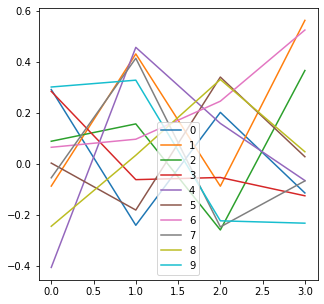

In [33]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

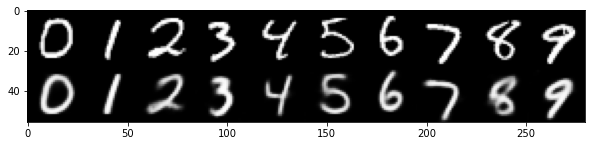

In [34]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [35]:
from XAE.sampler import gaus

exn = 5

In [36]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

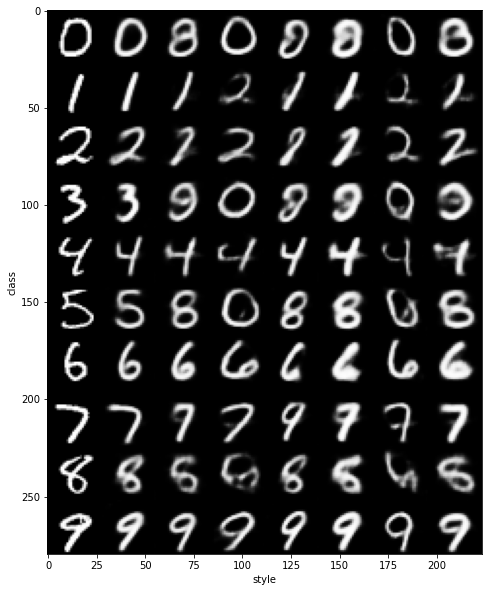

In [37]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [38]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

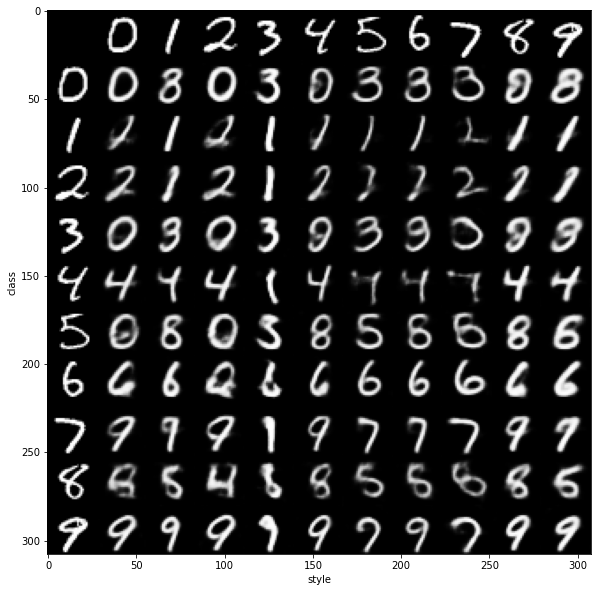

In [39]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()